# AI-Powered Calendar Assistant: Meeting Classification and Departure Time Prediction - Andrew Nordstrom


## Project Overview

In this project, we aim to develop a machine learning-powered AI assistant that classifies calendar invites into **onsite, offsite, or online meetings**. 

### Key Objectives:
- **Meeting Classification:** Utilize Natural Language Processing (NLP) to analyze meeting details and categorize them as onsite, offsite, or online.
- **Model Evaluation:** Assess model performance using accuracy, precision, recall, and confusion matrix analysis for classification, and MAE/RMSE for regression.

By the end of this notebook, we will have trained and evaluated a machine learning pipeline that enhances scheduling efficiency and improves time management for professionals.


In [33]:
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [34]:
# Load dataset from CSV
df = pd.read_csv("meeting_invites.csv")

In [35]:
df.head

<bound method NDFrame.head of      meeting_id  user_id                                    office_location  \
0           1-1        1   68081 David Pines Apt. 695, Port Brian, SD 75606   
1           1-2        1   68081 David Pines Apt. 695, Port Brian, SD 75606   
2           1-3        1   68081 David Pines Apt. 695, Port Brian, SD 75606   
3           1-4        1   68081 David Pines Apt. 695, Port Brian, SD 75606   
4           1-5        1   68081 David Pines Apt. 695, Port Brian, SD 75606   
...         ...      ...                                                ...   
4995      50-96       50  6859 Gallagher Heights Apt. 840, South Maryche...   
4996      50-97       50  6859 Gallagher Heights Apt. 840, South Maryche...   
4997      50-98       50  6859 Gallagher Heights Apt. 840, South Maryche...   
4998      50-99       50  6859 Gallagher Heights Apt. 840, South Maryche...   
4999     50-100       50  6859 Gallagher Heights Apt. 840, South Maryche...   

                     

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   meeting_id         5000 non-null   object
 1   user_id            5000 non-null   int64 
 2   office_location    5000 non-null   object
 3   title              5000 non-null   object
 4   start_time         5000 non-null   object
 5   end_time           5000 non-null   object
 6   location           5000 non-null   object
 7   organizer          5000 non-null   object
 8   description        5000 non-null   object
 9   attendance_choice  5000 non-null   object
 10  optional           5000 non-null   bool  
dtypes: bool(1), int64(1), object(9)
memory usage: 395.6+ KB


## Feature Engineering and Logistic Regression Model

### 1. Data Transformation
To improve model performance, we perform several feature engineering steps:
- **Datetime Conversion:** Convert `start_time` and `end_time` to datetime format for easier manipulation.
- **Feature Extraction:**
  - Extract the **start hour** from `start_time` to capture time-based patterns.
  - Compute **meeting duration (in minutes)** by calculating the difference between `end_time` and `start_time`.
- **Boolean Conversion:** Convert the `optional` flag (True/False) into an integer (1/0) for model compatibility.
- **Target Encoding:** Encode the target variable:
  - `attended_online` → **1**
  - `attended_in_person` → **0**

### 2. Feature Selection
The model uses the following numerical features:
- `start_hour`: When the meeting starts (hour of the day).
- `duration`: Length of the meeting in minutes.
- `optional_flag`: Whether the meeting is optional (1) or required (0).

### 3. Data Preprocessing Pipeline
A **ColumnTransformer** is used to scale numerical features using `StandardScaler()`.

### 4. Model Selection
A **Logistic Regression model** is trained using a pipeline:
- The **preprocessor** standardizes numerical features.
- The **classifier** is a logistic regression model (`solver='liblinear'` for small datasets).

### 5. Model Training and Evaluation
- The dataset is split into **80% training** and **20% testing** (`train_test_split`).
- The model is **fitted** on the training data.
- Predictions are **evaluated** using:
  - **Accuracy Score**: Measures overall performance.
  - **Classification Report**: Provides precision, recall, and F1-score.

This baseline model serves as a starting point for further improvements in meeting classification.


In [37]:
# Convert start_time and end_time to datetime
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])

# Extract start_hour from start_time
df['start_hour'] = df['start_time'].dt.hour

# Calculate meeting duration in minutes
df['duration'] = (df['end_time'] - df['start_time']).dt.total_seconds() / 60

# Convert the boolean optional field to integer (True -> 1, False -> 0)
df['optional_flag'] = df['optional'].astype(int)

# Encode target variable: attended_online = 1, attended_in_person = 0
df['target'] = df['attendance_choice'].apply(lambda x: 1 if x == 'attended_online' else 0)

In [38]:
# Define features to use in the model
features = ['start_hour', 'duration', 'optional_flag']
X = df[features]
y = df['target']

In [39]:
# creating a simple preprocessing pipeline that scales the numeric features
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), features)
])

In [40]:
# Create a pipeline that first preprocesses then fits logistic regression
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

In [41]:
# Split the data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the logistic regression baseline model
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))

print("\nClassification Report:\n",classification_report(y_test, y_pred, zero_division=0))


Accuracy: 0.555

Classification Report:
               precision    recall  f1-score   support

           0       0.56      1.00      0.71       555
           1       0.00      0.00      0.00       445

    accuracy                           0.56      1000
   macro avg       0.28      0.50      0.36      1000
weighted avg       0.31      0.56      0.40      1000



When using only numerical features (such as start_hour, duration, and optional_flag), the model performance was very poor. The model achieved an accuracy of 55.5% and completely failed to predict any instances for class 1.  

In [42]:
# Load dataset from CSV
df = pd.read_csv("meeting_invites.csv")

# Convert start_time and end_time to datetime
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])

# Extract start_hour from start_time
df['start_hour'] = df['start_time'].dt.hour

# Calculate meeting duration in minutes
df['duration'] = (df['end_time'] - df['start_time']).dt.total_seconds() / 60

# Convert the boolean optional field to integer (True -> 1, False -> 0)
df['optional_flag'] = df['optional'].astype(int)

# Encode target variable: attended_online = 1, attended_in_person = 0
df['target'] = df['attendance_choice'].apply(lambda x: 1 if x == 'attended_online' else 0)

# Define features
numeric_features = ['start_hour', 'duration', 'optional_flag']
text_features = ['title'] 

# Create a ColumnTransformer that scales numerical features and vectorizes text features.
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('text', TfidfVectorizer(), 'title')
])

# Create a pipeline that preprocesses the data and then fits logistic regression.
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', class_weight='balanced'))
])

# Define X and y.
X = df[numeric_features + text_features]
y = df['target']

# Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the logistic regression model.
pipeline.fit(X_train, y_train)

# Predict on the test set.
y_pred = pipeline.predict(X_test)

# Evaluate the model.
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))


Accuracy: 0.506

Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.51      0.53       555
           1       0.45      0.51      0.48       445

    accuracy                           0.51      1000
   macro avg       0.51      0.51      0.50      1000
weighted avg       0.51      0.51      0.51      1000



After trying to to scale numeric features and vectorize text features the model still produce poor performance.

In [43]:


# Load dataset from CSV
df = pd.read_csv("meeting_invites.csv")

# Convert start_time and end_time to datetime
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])

# Extract numeric features:
# 1. start_hour from start_time.
df['start_hour'] = df['start_time'].dt.hour
# 2. Duration in minutes.
df['duration'] = (df['end_time'] - df['start_time']).dt.total_seconds() / 60
# 3. Convert boolean 'optional' to an integer flag.
df['optional_flag'] = df['optional'].astype(int)

# Combine text features: we'll merge the title and description.
df['text'] = df['title'] + " " + df['description']

# Encode the target variable:
# attended_online = 1, attended_in_person = 0
df['target'] = df['attendance_choice'].apply(lambda x: 1 if x == 'attended_online' else 0)

# Define feature lists
numeric_features = ['start_hour', 'duration', 'optional_flag']
text_features = ['text']

# Create a ColumnTransformer to preprocess numeric and text features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('text', TfidfVectorizer(), 'text')
    ]
)

# Build the pipeline with RandomForestClassifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Define X and y
X = df[numeric_features + text_features]
y = df['target']

# Split data into training and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))


Accuracy: 0.692

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.84      0.75       555
           1       0.71      0.51      0.60       445

    accuracy                           0.69      1000
   macro avg       0.70      0.67      0.67      1000
weighted avg       0.70      0.69      0.68      1000



## Meeting Classification with Text and Numeric Features

### 1. Data Loading and Preprocessing
- Load the dataset from a CSV file.
- Convert `start_time` and `end_time` into **datetime format** for accurate time-based calculations.
- Extract **numerical features**:
  - `start_hour`: The hour when the meeting starts.
  - `duration`: Meeting length in minutes.
  - `optional_flag`: Whether the meeting is optional (converted from boolean to integer).
- Create a **combined text feature** using `title` and `description` to enhance text-based classification.
- Encode the **target variable**:
  - `attended_online` → **1**
  - `attended_in_person` → **0**

### 2. Feature Engineering
- Define **numeric features**: `start_hour`, `duration`, `optional_flag`
- Define **text feature**: Combined `title` and `description`
- Construct a **ColumnTransformer** to process both:
  - **Numerical features**: Standardized using `StandardScaler()`
  - **Text features**: Vectorized using `TfidfVectorizer()`

### 3. Model Training and Hyperparameter Tuning
- Build a **machine learning pipeline** that:
  1. **Preprocesses the data** (scales numerical features and vectorizes text).
  2. **Applies a RandomForestClassifier** to classify meetings.
- Split the data into **training (80%)** and **test (20%)** sets.
- Use **GridSearchCV** to optimize hyperparameters:
  - Tune **TF-IDF vectorization** (n-gram range, max features).
  - Tune **Random Forest** hyperparameters (number of estimators, max depth, min samples per leaf).

### 4. Model Evaluation
- **Best Model Selection**: GridSearchCV finds the optimal hyperparameters for classification.
- **Performance Metrics**:
  - **Best Parameters**: Output the best configuration for Random Forest and TF-IDF.
  - **Cross-Validation Accuracy**: Evaluate performance on different training splits.
  - **Test Accuracy**: Assess generalization to unseen data.
  - **Classification Report**: Analyze precision, recall, and F1-score.

This approach leverages **both structured (numeric) and unstructured (text) data** to classify meeting attendance effectively while optimizing the model for better accuracy.


In [44]:


# Load dataset from CSV
df = pd.read_csv("meeting_invites.csv")

# Convert start_time and end_time to datetime
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])

# Extract numeric features
df['start_hour'] = df['start_time'].dt.hour
df['duration'] = (df['end_time'] - df['start_time']).dt.total_seconds() / 60
df['optional_flag'] = df['optional'].astype(int)

# Combine text features (using both title and description)
df['text'] = df['title'] + " " + df['description']

# Encode target variable: attended_online = 1, attended_in_person = 0
df['target'] = df['attendance_choice'].apply(lambda x: 1 if x == 'attended_online' else 0)

# Define feature lists
numeric_features = ['start_hour', 'duration', 'optional_flag']
text_feature = 'text'

# Create a ColumnTransformer to process both numeric and text features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('text', TfidfVectorizer(), text_feature)
    ]
)

# Build a pipeline that preprocesses the data and then applies RandomForestClassifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Split the data into training and test sets
X = df[numeric_features + [text_feature]]
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a parameter grid for GridSearchCV
param_grid = {
    # Parameters for TfidfVectorizer within the 'preprocessor'
    'preprocessor__text__ngram_range': [(1, 1), (1, 2)],
    'preprocessor__text__max_features': [None, 500, 1000],
    # Parameters for RandomForestClassifier
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_leaf': [1, 3, 5]
}

# Setup GridSearchCV
grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=3, 
    n_jobs=-1, 
    scoring='accuracy', 
    verbose=1
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Output the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

# Evaluate on the test set
y_pred = grid_search.predict(X_test)
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 3, 'classifier__n_estimators': 100, 'preprocessor__text__max_features': 500, 'preprocessor__text__ngram_range': (1, 2)}
Best CV Accuracy: 0.7007561485573791

Test Accuracy: 0.699

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.87      0.76       555
           1       0.75      0.48      0.59       445

    accuracy                           0.70      1000
   macro avg       0.71      0.68      0.68      1000
weighted avg       0.71      0.70      0.69      1000



In [45]:
import numpy as np
from sklearn.metrics import classification_report

# Get predicted probabilities for the positive class (attended_online, i.e., class 1)
y_probs = grid_search.predict_proba(X_test)[:, 1]

# Adjust the threshold: e.g., use 0.4 instead of the default 0.5
threshold = 0.4
y_pred_adjusted = (y_probs > threshold).astype(int)

print("Threshold:", threshold)
print(classification_report(y_test, y_pred_adjusted, zero_division=0))


Threshold: 0.4
              precision    recall  f1-score   support

           0       0.68      0.87      0.76       555
           1       0.75      0.49      0.59       445

    accuracy                           0.70      1000
   macro avg       0.72      0.68      0.68      1000
weighted avg       0.71      0.70      0.69      1000



In [46]:
from sklearn.metrics import precision_score, recall_score, f1_score

for t in [0.3, 0.35, 0.4, 0.45]:
    y_pred_t = (y_probs > t).astype(int)
    prec = precision_score(y_test, y_pred_t, zero_division=0)
    rec = recall_score(y_test, y_pred_t, zero_division=0)
    f1 = f1_score(y_test, y_pred_t, zero_division=0)
    print(f"Threshold: {t:.2f} | Precision: {prec:.2f} | Recall: {rec:.2f} | F1: {f1:.2f}")


Threshold: 0.30 | Precision: 0.45 | Recall: 0.97 | F1: 0.62
Threshold: 0.35 | Precision: 0.66 | Recall: 0.58 | F1: 0.62
Threshold: 0.40 | Precision: 0.75 | Recall: 0.49 | F1: 0.59
Threshold: 0.45 | Precision: 0.75 | Recall: 0.48 | F1: 0.59


In [47]:
from sklearn.metrics import classification_report

# Get predicted probabilities for the positive class (attended_online, i.e., class 1)
y_probs = grid_search.predict_proba(X_test)[:, 1]

# Adjust the threshold: e.g., use 0.7 instead of the default 0.5 to favor in-person
threshold = 0.7
y_pred_adjusted = (y_probs > threshold).astype(int)

print("Threshold:", threshold)
print(classification_report(y_test, y_pred_adjusted, zero_division=0))


Threshold: 0.7
              precision    recall  f1-score   support

           0       0.66      0.89      0.75       555
           1       0.75      0.42      0.54       445

    accuracy                           0.68      1000
   macro avg       0.70      0.65      0.65      1000
weighted avg       0.70      0.68      0.66      1000



## Meeting Attendance Classification Using Text Features

### 1. Data Loading
- Load the dataset from a CSV file containing meeting invite details.
- The dataset includes key fields such as `title`, `location`, and `attendance_choice`.

### 2. Data Preprocessing and Feature Engineering
- **Text Feature Engineering:** A **combined text feature** is created by merging the `title` and `location` columns. This helps capture contextual information for classification.
- **Target Encoding:** The `attendance_choice` column is transformed into binary labels:
  - `attended_online` → **1**
  - `attended_in_person` → **0**

### 3. Train-Test Split
- The dataset is split into **80% training** and **20% testing** using `train_test_split` for model evaluation.
- Features: `combined_text` (meeting details).
- Target: `attendance_choice` (binary classification).

### 4. Model Pipeline Construction
- A **pipeline** is built to automate preprocessing and model training:
  1. **TF-IDF Vectorization:** Converts text into numerical representations, capturing word importance.
  2. **Random Forest Classifier:** A decision-tree-based ensemble model trained on vectorized text data.

### 5. Model Evaluation
- **Predictions:** The trained model classifies whether a meeting was attended online or in person.
- **Performance Metrics:**
  - **Accuracy Score**: Measures overall classification performance.
  - **Classification Report**: Provides precision, recall, and F1-score breakdown.

### 6. Confusion Matrix and Error Analysis
- A **confusion matrix** is generated to visualize the model’s performance, identifying correctly and incorrectly classified instances.
- The matrix is displayed using `ConfusionMatrixDisplay`, highlighting potential areas for improvement.

This approach leverages **Natural Language Processing (NLP) with TF-IDF and machine learning (Random Forest)** to predict meeting attendance based on meeting details.


Accuracy: 0.928

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       555
           1       0.94      0.89      0.92       445

    accuracy                           0.93      1000
   macro avg       0.93      0.92      0.93      1000
weighted avg       0.93      0.93      0.93      1000

Confusion Matrix:
[[531  24]
 [ 48 397]]


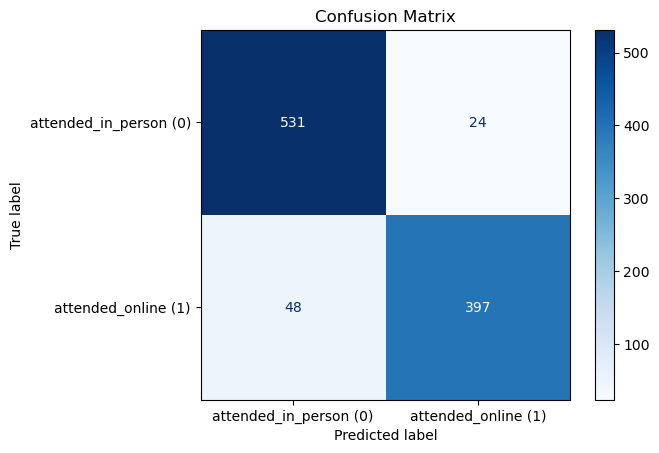

In [48]:
# =============================================================================
# Step 1: Data Loading
# =============================================================================

# Load the dataset from CSV
df = pd.read_csv("meeting_invites.csv")

# =============================================================================
# Step 2: Data Preprocessing and Feature Engineering
# =============================================================================
# Create a combined text feature from 'title' and 'location'
df['combined_text'] = df['title'] + " " + df['location']

# Encode the target variable:
# We'll set attended_online = 1, and attended_in_person = 0.
df['target'] = df['attendance_choice'].apply(lambda x: 1 if x == 'attended_online' else 0)

# =============================================================================
# Step 3: Split the Data into Training and Testing Sets
# =============================================================================
X = df[['combined_text']]
y = df['target']

# Use an 80/20 train/test split with a fixed random state for reproducibility.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# =============================================================================
# Step 4: Build the Model Pipeline
# =============================================================================
# The pipeline consists of two parts:
# 1. TF-IDF Vectorization: Converts the combined text into numeric features.
# 2. Random Forest Classifier: Trains the model using the vectorized text.
pipeline = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_features=1000)),
    ('classifier', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42))
])

# Train the pipeline on the training data
pipeline.fit(X_train['combined_text'], y_train)

# =============================================================================
# Step 5: Model Evaluation
# =============================================================================
# Predict on the test set
y_pred = pipeline.predict(X_test['combined_text'])

# Calculate and print the accuracy and detailed classification report
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# =============================================================================
# Step 6: Confusion Matrix and Error Analysis
# =============================================================================
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['attended_in_person (0)', 'attended_online (1)'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


## Model Performance Evaluation

### 1. Accuracy
The model achieved an **accuracy of 92.8%**, meaning it correctly classified meeting attendance in approximately **93 out of 100 cases**.

### 2. Classification Report
The classification report provides a breakdown of model performance for each class:

| Metric       | Attended In-Person (0) | Attended Online (1) | Macro Avg | Weighted Avg |
|-------------|---------------------|-----------------|-----------|--------------|
| **Precision** | 0.92                | 0.94            | 0.93      | 0.93         |
| **Recall**    | 0.96                | 0.89            | 0.92      | 0.93         |
| **F1-Score**  | 0.94                | 0.92            | 0.93      | 0.93         |
| **Support**   | 555                 | 445             | —         | 1000         |

- **Precision**: When the model predicts a class (in-person or online), how often is it correct?
- **Recall**: Out of all actual instances of a class, how many did the model correctly identify?
- **F1-Score**: A balance between precision and recall.

The model performs **slightly better at predicting in-person attendance (0)**, with a **higher recall (96%)**, meaning it rarely misclassifies an in-person meeting as online. The model’s **recall for online attendance (1) is 89%**, indicating some missed instances.

### 3. Confusion Matrix
The confusion matrix shows the breakdown of correct and incorrect predictions:

| Actual ↓ / Predicted → | In-Person (0) | Online (1) |
|----------------------|-------------|------------|
| **In-Person (0)**  | **531** (True Negatives) | 24 (False Positives) |
| **Online (1)**      | 48 (False Negatives) | **397** (True Positives) |

- **531 True Negatives**: Correctly predicted in-person meetings.
- **397 True Positives**: Correctly predicted online meetings.
- **24 False Positives**: Meetings wrongly classified as online.
- **48 False Negatives**: Meetings wrongly classified as in-person.

### 4. Summary and Next Steps
- The model demonstrates **strong overall performance** with balanced precision and recall.
- The **lower recall for online meetings (1)** suggests potential improvements, such as **enhancing text feature extraction or adjusting model parameters**.
- Future improvements may include **fine-tuning the Random Forest model, experimenting with different n-gram ranges in TF-IDF, or integrating additional contextual features**.

This evaluation provides a solid foundation for refining the classification model to achieve even **higher accuracy and balanced performance**.


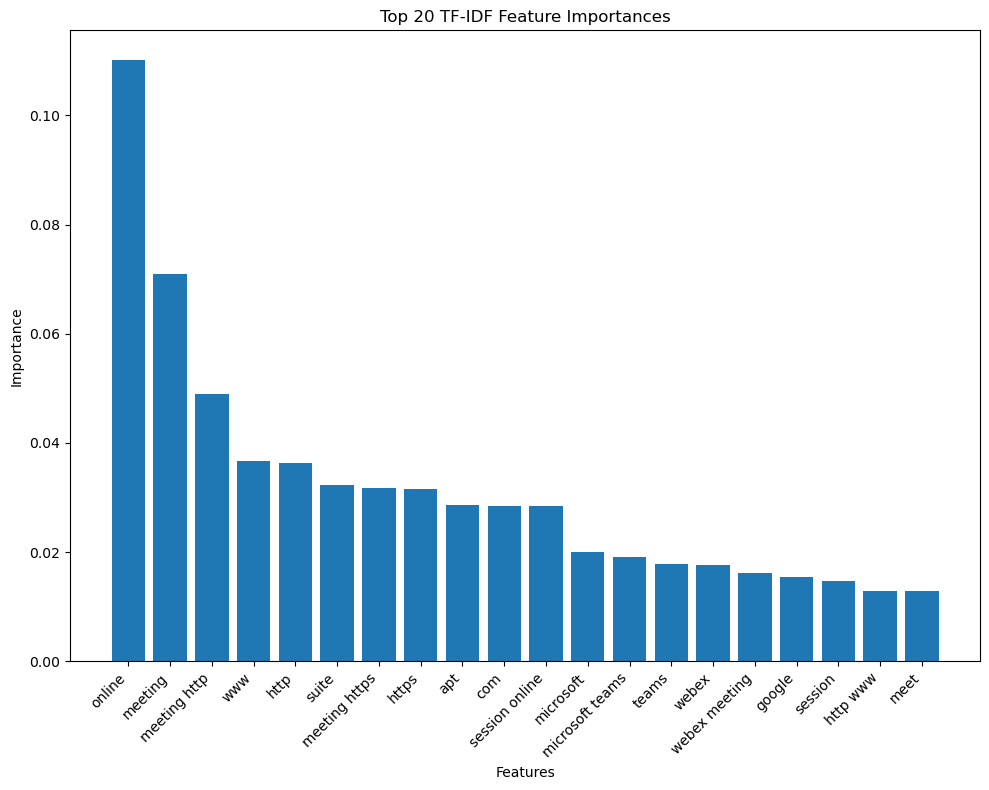

In [49]:
# Extract the vectorizer and classifier from the pipeline
tfidf_vectorizer = pipeline.named_steps['tfidf']
classifier = pipeline.named_steps['classifier']

# Get feature names from TF-IDF
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# Get feature importances for the TF-IDF features only.
# Note: This requires that the classifier's feature_importances_ correspond to the TF-IDF part.
# In a pipeline that combines TF-IDF and numeric features, you'll need to align them appropriately.
# For this example, let's assume our classifier only sees TF-IDF features.

importances = classifier.feature_importances_
# Sort indices by importance
indices = np.argsort(importances)[::-1]

# Plot the top 20 features
plt.figure(figsize=(10, 8))
plt.title("Top 20 TF-IDF Feature Importances")
plt.bar(range(20), importances[indices][:20], align='center')
plt.xticks(range(20), [tfidf_feature_names[i] for i in indices][:20], rotation=45, ha="right")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


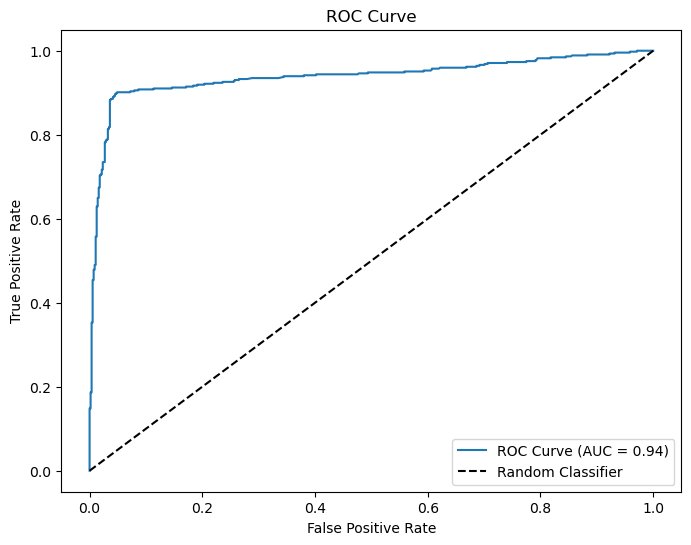

In [50]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get predicted probabilities for class 1 (attended_online)
y_probs = pipeline.predict_proba(X_test['combined_text'])[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()
